# Generative Adverserial Imitation Learning

Generative Adversarial Imitation Learning (GAIL) was first proposed in the paper [Generative Adversarial Imitation Learning](https://arxiv.org/abs/1606.03476) by Jonathan Ho and Stefano Ermon. The project task is to implement the Generative Adverserial Imitation Learning model for driving scenarios using the BARK-simulator.

GAIL is based on the setting of Reinforcement Learning (RL). In Reinforcment Learning, the agent interacts with the environment through its actions and receives rewards in return. The aim of the learning process is to maximize the cummulative reward by chosing the best action in all states.

As the name suggests, GAIL belongs to a smaller subgroup of RL, called Imitation Learning. In this setup the goal of the agent is to mimic an expert behavior as closely as possible. The environment awards higher rewards to expert-like behavior and smaller ones to actions which substantially deviate from the expert behavior. In our case, expert trajectories were generated from real life data, namely from the Interaction Dataset, as well as from a pretrained SAC (Soft Actor-Critic) agent. The expert trajectories, which are obtained in this way, represent the expert knowledge by containing many states with corresponding actions that were produced by the expert.

As mentioned previously, learning of the agent in the RL setting is driven by the rewards it receives from the environment. The amount of the reward in the Imitation Learning setting are determined based on how closely the agent mimics the expert behavior. Special in the GAIL approach is that we receive the reward from an adversarial game: The agent is represented by a generator network which is trained based on the feedback of a discriminator network. The generator produces actions for given states which are then evaluated by the discriminator. In the meantime, the discriminator is trained by feeding it with expert and agent state-action pairs for classification. This way, the generator tries to fool the discriminator, hence he aims at acting as expert-like as possible. Meanwhile, the discriminator tries to distinguish between expert and agent trajectories. Intuitively, learning converges when the generator learned to act so similarly to the expert that the discriminator cannot tell apart expert and agent trajectories any more. In game theory this point is called the Nash-equilibrium.

In practice, the implementation of a GAIL agent is usually solved in the following way for sample efficiency: The agent interacts with the environment by following its actual policy and hence agent state-action pairs are generated. These points are stored in a replay buffer for further learning. After a specified interval a training step is carried out. This training step has 2 substeps: training the discriminator and training the generator networks. 
* __Discriminator training:__ The discriminator is fed a batch of expert (from the expert trajectories) and agent (from the replay buffer) state-action pairs. It classifies all of them. Based on their true labels the loss is calculated and a gradient descent step is carried out in order to minimize the loss.
* __Generator training:__ The generator is fed a batch of states from the replay buffer and it produces actions for them. The resulting state-action pairs are fed to the discriminator for classification. The negative output of the discriminator is used as a loss for the generator network. (Close to -1 if the agent mimics the expert successfully.) The gradient of the loss is propagated all the way back to the generator network to carry out a gradient step to minimize its loss.<br>
As already stated, training runs until both, the generator and the discriminator loss, converge to a steady state value.


The training process is visualized in the following figure:


<img width=70% src="files/data/gail_overview.gif">

# Interaction Dataset
As data source, we use the Interaction Dataset: https://arxiv.org/abs/1910.03088. We are interested in the merging scenarios: 
* DR_DEU_Merging_MT
* DR_CHN_Merging_ZS

These scenarios contain a map specification and track specifications for multiple vehicles that drive on the map. The tracks represent the trajectories of the vehicles which consist of a number of consecutive recorded states. 

Have a look how the Interaction Dataset is [integrated in BARK](https://github.com/bark-simulator/bark/blob/setup_tutorials/docs/tutorials/04_interaction_dataset.ipynb). 
(Note that the dataset itself is NOT enclosed within BARK due to license limitations)

# Expert Trajectories

The Interaction Dataset of course contains trajectories of many different vehicles with different wheel bases. As there are only states recorded in the dataset, we calculate the action the vehicle has taken to go from one state to the next ourselfs.

The wheel base is used to calculate the action following the [Single Track Model](https://borrelli.me.berkeley.edu/pdfpub/IV_KinematicMPC_jason.pdf). As we are only interested in trajectories with a wheel base as of our agent, we use a fixed wheel base when calculating the actions from the successive states. This however does not restrict the accuracy of the data. We just consider that all state trajectories were carried out by the same car and calculate the actions that a car would have needed to carry out that behavior. 

As the state variables and also the actions have different magnitudes, we normalize all of them for training. The normalization of the expert trajectories takes place while loading the generated expert trajectories. The loading function also takes the current environment (BARK runtime) as an input, hence the trajectories are normalized according to the current parameters (Current state and action spaces).

You can have a look at the source code in `bark_ml.library_wrappers.lib_tf2rl.generate_expert_trajectories`

# Generate Expert Trajectories
A short example script for generating expert trajectories from the interaction dataset is shown in the following. 

In [1]:
import os 
import bark
from pprint import pprint
from bark_ml.library_wrappers.lib_tf2rl.generate_expert_trajectories import *

tracks_folder = os.path.join(os.getcwd(), 'data')
map_file = os.path.join(os.getcwd(), 'data/DR_DEU_Merging_MT_v01_shifted.xodr')
known_key = ('DR_DEU_Merging_MT_v01_shifted', 'vehicle_tracks_013')
ego_agent = 66

param_server = create_parameter_servers_for_scenarios(map_file, tracks_folder)[known_key]
generation_params = param_server["Scenario"]["Generation"]["InteractionDatasetScenarioGeneration"]
generation_params["TrackIds"] = [63, 64, 65, 66, 67, 68]
generation_params["StartTs"] = 232000
generation_params["EndTs"] = 259000
generation_params["EgoTrackId"] = ego_agent
param_server["Scenario"]["Generation"]["InteractionDatasetScenarioGeneration"] = generation_params

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


/home/brucknem/.cache/bazel/_bazel_brucknem/5babddc60bc977a08450e544bfdcfbae/execroot/bark_ml/bazel-out/k8-fastbuild/bin/docs/report/run.runfiles/bark_project/bark/runtime/viewer/matplotlib_viewer.py:49: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  linewidth=linewidth)
/home/brucknem/.cache/bazel/_bazel_brucknem/5babddc60bc977a08450e544bfdcfbae/execroot/bark_ml/bazel-out/k8-fastbuild/bin/docs/report/run.runfiles/bark_project/bark/runtime/viewer/matplotlib_viewer.py:49: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  linewidth=linewidth)
/home/brucknem/.cache/bazel/_bazel_brucknem/5babddc60bc977a08450e544bfdcfbae/execroot/bark_ml/bazel-out/k8-fastbuild/bin/docs/report/run.runfiles/bark_project/bark/runtime/viewer/matplotlib_viewer.py:49: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated 

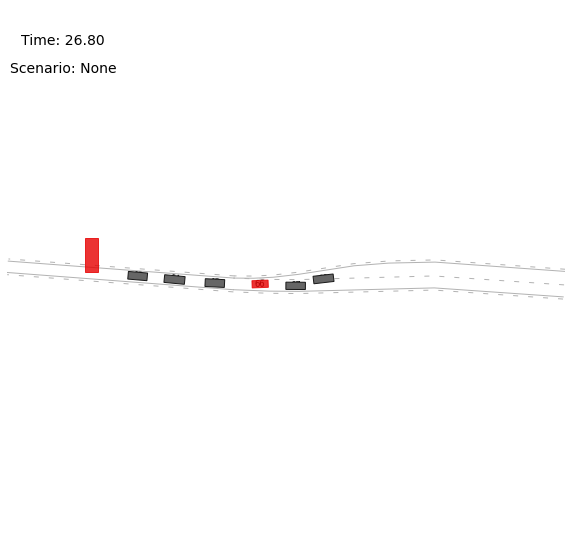

In [2]:
expert_trajectories = generate_expert_trajectories_for_scenario(param_server, sim_time_step=200, renderer="matplotlib_jupyter")

In [3]:
import pandas as pd
from IPython.display import display
from helpers import *

## The generated expert trajectories
The generated expert trajectories are stored in a dictionary with key-value pairs:
* `obs`: list, contains the observation vector for the timestep.
* `act`: list, contains the action that was carried out in that timestep.
* `next_obs`: list, contains the next observation after carrying out the action `act` in the state `obs`. 

### Format of observations

\begin{align*}
\begin{pmatrix}
x \\
y \\
\Theta \\
v
\end{pmatrix}
\text{ for the ego vehicle and the three nearest vehicles in the scene, where $x$ and $y$ are 2D coordinates, $\Theta$ is orientation and $v$ velocity.}
\end{align*}

Stored as `expert_trajectories[ego_agent]['obs']` 

In [4]:
# Small number of observations for our agent

pd.options.display.float_format = '{:,.2f}'.format
display(observations_to_dataframe(expert_trajectories[ego_agent]['obs'][:5]))

,x (0),y (0),Theta (0),v (0),x (1),y (1),Theta (1),v (1),x (2),y (2),Theta (2),v (2),x (3),y (3),Theta (3),v (3)
0,998.18,"1,006.94",3.09,2.20,995.96,"1,004.27",3.06,1.66,"1,004.67","1,006.34",3.06,1.80,"1,004.06","1,003.58",3.07,1.93
1,997.75,"1,006.96",3.09,2.19,995.63,"1,004.30",3.06,1.63,"1,004.32","1,006.37",3.06,1.78,"1,003.68","1,003.61",3.08,1.83
2,997.31,"1,006.99",3.09,2.18,995.31,"1,004.33",3.06,1.59,"1,003.97","1,006.40",3.06,1.76,"1,003.32","1,003.63",3.08,1.72
3,996.88,"1,007.01",3.09,2.17,994.99,"1,004.35",3.06,1.56,"1,003.61","1,006.42",3.06,1.74,"1,002.98","1,003.65",3.08,1.62
4,996.44,"1,007.04",3.08,2.15,994.68,"1,004.38",3.06,1.53,"1,003.27","1,006.45",3.06,1.74,"1,002.66","1,003.67",3.08,1.52


### Format of actions
\begin{align*}
\begin{pmatrix}
a \\
\delta 
\end{pmatrix}
\text{, where $a$ is acceleration and $\delta$ is steering angle.}
\end{align*}

Stored as `expert_trajectories[ego_agent]['act']` 

In [5]:
# Small number of actions from our agent

pd.options.display.float_format = '{:,.6f}'.format
display(actions_to_dataframe(expert_trajectories[ego_agent]['act'][:5]))

,Acceleration,Steering angle
0,-0.034666,0.000000
1,-0.044928,-0.006168
2,-0.069888,0.000000
3,-0.099838,-0.006234
4,-0.120089,0.000000


---

# GAIL implementation
The following section describes the implementation details we chose to implement the Generative Adverserial Imitation Learning setup.

## TF2RL implementation
We use an off the shelf implementation, the library [TF2RL](https://github.com/keiohta/tf2rl). It implements several reinforcement learning algorithms in [tensorflow 2](https://www.tensorflow.org/guide/effective_tf2). 

The GAIL agent is built up as follows:
* __Generator:__ A complete DDPG agent with actor and critic networks. Both of them have 2-2 hidden layers.
* __Discriminator:__ A normal discriminator network with 2 hidden layers.

In this respect, the agent is not in the traditional GAIL setup with 2 neural networks. Instead, it has 5 networks, since the DDPG agent itself has 4 networks for greater stability during training. The DDPG agent's critic network receives the judgement of the discriminator network as the reward from the environment and its training aims to maximize this reward.

## Integration into BARK
The TF2RL based GAIL agent is integrated into the existing BARK concepts and is implemented in the following most important classes:
* __TF2RLWrapper:__ Wraps the BARK runtime to match the expectations of TF2RL about the environment. The observation and action normalization also takes place here.
    * Source: `bark_ml/library_wrappers/lib_tf2rl/tf2rl_wrapper.py`
* __BehaviorTF2RLAgent:__ Base class for TF2RL based agents.
    * Source: `bark_ml/library_wrappers/lib_tf2rl/agents/tf2rl_agent.py`
* __BehaviorGAILAgent:__ The TF2RL based GAIL agent.
    * Source: `bark_ml/library_wrappers/lib_tf2rl/agents/gail_agent.py`
* __TF2RLRunner:__ Base class for TF2RL based runners.
    * Source: `bark_ml/library_wrappers/lib_tf2rl/runners/tf2rl_runner.py`
* __GAILRunner:__ The TF2RL based GAIL runner.
    * Source: `bark_ml/library_wrappers/lib_tf2rl/runners/gail_runner.py`
    
In the followings the training process is demonstrated. Later the performance of a pre-trained agent can be visualized.

---

# Training
We will now train a GAIL agent using the implementation described above. There are several training parameters which can be set on demand:
* The number of steps to train for
* The frequency of testing during training
* The number of episodes in each testing round
* The usage of GPU accelerated calculations

In [6]:
# Customize some parameters here!

max_steps = 100000          # Number of steps to train for.
test_interval = 100         # test in every ... steps.
test_episodes = 5           # number of test episodes.
gpu = 0                     # use -1 for cpu only.

In [7]:
# imports
import os
from pathlib import Path

# BARK imports
from bark_project.bark.runtime.commons.parameters import ParameterServer
from bark.runtime.viewer.matplotlib_viewer import MPViewer
from bark.runtime.viewer.video_renderer import VideoRenderer

# BARK-ML imports
from bark_ml.environments.blueprints import ContinuousHighwayBlueprint, \
  ContinuousMergingBlueprint, ContinuousIntersectionBlueprint
from bark_ml.environments.single_agent_runtime import SingleAgentRuntime
from bark_ml.library_wrappers.lib_tf2rl.tf2rl_wrapper import TF2RLWrapper
from bark_ml.library_wrappers.lib_tf2rl.agents.gail_agent import BehaviorGAILAgent
from bark_ml.library_wrappers.lib_tf2rl.runners.gail_runner import GAILRunner
from bark_ml.library_wrappers.lib_tf2rl.load_expert_trajectories import load_expert_trajectories

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Training graphs

The next cell deletes the previous logs and launches tensorboard. After tensorboard has launched, please go on to the next cell and start the training. The tensorboard window refreshes itself every 30 seconds, but you can also refresh it manually in the upper right corner.

You should see the graphs for:
* **Common**
    * Common/average_step_count: The average number of steps the agent takes in the environment per scenario
    * Common/average_test_return: The average return during the test scenarios
    * Common/fps: The steps the agent takes in the environment per second
    * Common/training_return: The per scenario return of the agent during training
* **DDPG**
    * DDPG/actor_loss: The loss of the actor network
    * DDPG/critic_loss: The loss of the critic network
* **GAIL**
    * GAIL/Accuracy: The agent/expert distinguishing accuracy of the discriminator
    * GAIL/DiscriminatorLoss: The loss of the discriminator network
    * GAIL/JSdivergence: The Jensen–Shannon divergence measuring the similarity between the expert and agent

The GAIL agent should converge to a Common/average_test_return of 1, so success in every scenario it faces, after at most 10.000 scenarios. If it doesn't converge, then the initial network weights were not well drawn. This is a common problem in the Generative Adverserial setup. In this case, please rerun the training, as the network weights are then newly initialized at random.

***

Sometimes tensorboard does not refresh correctly. If you don't see all of the above graphs after 300 scenarios, please rightclick the tensorboard and click _Reload frame_.

In [8]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# launching tensorboard and deleting the previous runs logdirs:
%rm -r "data/logs"
%mkdir "data/logs"
%tensorboard --logdir "data/logs" --port=60060

/home/brucknem/.cache/bazel/_bazel_brucknem/5babddc60bc977a08450e544bfdcfbae/execroot/bark_ml/bazel-out/k8-fastbuild/bin/docs/report/run.runfiles/bark_project/bark/runtime/commons/xodr_parser.py:108: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if lane.find("userData"):
13:02:44.428 [INFO] (trainer.py:65) Restored None
13:02:44.479 [INFO] (irl_trainer.py:73) Total Epi:     1 Steps:      17 Episode Steps:    17 Return: -1.0000 FPS: 348.99
13:02:44.790 [INFO] (irl_trainer.py:73) Total Epi:     2 Steps:      21 Episode Steps:     4 Return: -1.0000 FPS: 702.25
13:02:44.802 [INFO] (irl_trainer.py:73) Total Epi:     3 Steps:      35 Episode Steps:    14 Return:  1.0000 FPS: 1258.41
13:02:44.809 [INFO] (irl_trainer.py:73) Total Epi:     4 Steps:      38 Episode Steps:     3 Return: -1.0000 FPS: 568.36
13:02:44.821 [INFO] (irl_trainer.py:73) Total Epi:     5 Steps:      48 Episode Steps:    10 Return: 

13:02:45.308 [INFO] (irl_trainer.py:73) Total Epi:    66 Steps:     432 Episode Steps:     3 Return: -1.0000 FPS: 718.75
13:02:45.313 [INFO] (irl_trainer.py:73) Total Epi:    67 Steps:     434 Episode Steps:     2 Return: -1.0000 FPS: 545.92
13:02:45.318 [INFO] (irl_trainer.py:73) Total Epi:    68 Steps:     437 Episode Steps:     3 Return: -1.0000 FPS: 719.27
13:02:45.331 [INFO] (irl_trainer.py:73) Total Epi:    69 Steps:     451 Episode Steps:    14 Return: -1.0000 FPS: 1240.12
13:02:45.340 [INFO] (irl_trainer.py:73) Total Epi:    70 Steps:     459 Episode Steps:     8 Return: -1.0000 FPS: 1044.22
13:02:45.350 [INFO] (irl_trainer.py:73) Total Epi:    71 Steps:     468 Episode Steps:     9 Return: -1.0000 FPS: 1078.89
13:02:45.359 [INFO] (irl_trainer.py:73) Total Epi:    72 Steps:     474 Episode Steps:     6 Return: -1.0000 FPS: 912.87
13:02:45.393 [INFO] (irl_trainer.py:73) Total Epi:    73 Steps:     523 Episode Steps:    49 Return: -1.0000 FPS: 1470.76
13:02:45.410 [INFO] (irl_tra

13:02:45.934 [INFO] (irl_trainer.py:73) Total Epi:   134 Steps:     989 Episode Steps:    13 Return: -1.0000 FPS: 1272.10
13:02:45.941 [INFO] (irl_trainer.py:73) Total Epi:   135 Steps:     996 Episode Steps:     7 Return: -1.0000 FPS: 1140.01



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



13:02:48.467 [INFO] (irl_trainer.py:73) Total Epi:   136 Steps:    1006 Episode Steps:    10 Return: -1.0000 FPS:  3.96
13:02:48.566 [INFO] (irl_trainer.py:73) Total Epi:   137 Steps:    1010 Episode Steps:     4 Return: -1.0000 FPS: 41.10
13:02:48.695 [INFO] (irl_trainer.py:73) Total Epi:   138 Steps:    1015 Episode Steps:     5 Return: -1.0000 FPS: 39.08
13:02:49.052 [INFO] (irl_trainer.py:73) Total Epi:   139 Steps:    1029 Episode Steps:    14 Return: -1.0000 FPS: 39.36
13:02:49.178 [INFO] (irl_trainer.py:73) Total Epi:   140 Steps:    1034 Episode Steps:     5 Return: -1.0000 FPS: 40.34
13:02:49.518 [INFO] (irl_trainer.py:73) Total Epi:   141 Steps:    1047 Episode Steps:    13 Return: -1.0000 FPS: 38.39
13:02:49.626 [INFO] (irl_trainer.py:73) Total Epi:   142 Steps:    1051 Episode Steps:     4 Return: -1.0000 FPS: 37.22
13:02:49.738 [INFO] (irl_trainer.py:73) Total Epi:   143 Steps:    1055 Episode Steps:     4 Return: -1.0000 FPS: 36.44
13:02:49.835 [INFO] (irl_trainer.py:73) 

13:03:04.058 [INFO] (irl_trainer.py:73) Total Epi:   204 Steps:    1587 Episode Steps:    15 Return: -1.0000 FPS: 37.67
13:03:04.604 [INFO] (irl_trainer.py:73) Total Epi:   205 Steps:    1608 Episode Steps:    21 Return: -1.0000 FPS: 38.62
13:03:05.212 [INFO] (irl_trainer.py:73) Total Epi:   206 Steps:    1631 Episode Steps:    23 Return:  1.0000 FPS: 37.94
13:03:05.601 [INFO] (irl_trainer.py:73) Total Epi:   207 Steps:    1646 Episode Steps:    15 Return: -1.0000 FPS: 38.69
13:03:06.049 [INFO] (irl_trainer.py:73) Total Epi:   208 Steps:    1663 Episode Steps:    17 Return: -1.0000 FPS: 38.13
13:03:06.424 [INFO] (irl_trainer.py:73) Total Epi:   209 Steps:    1678 Episode Steps:    15 Return: -1.0000 FPS: 40.21
13:03:06.599 [INFO] (irl_trainer.py:73) Total Epi:   210 Steps:    1685 Episode Steps:     7 Return: -1.0000 FPS: 40.41
13:03:07.174 [INFO] (irl_trainer.py:73) Total Epi:   211 Steps:    1706 Episode Steps:    21 Return: -1.0000 FPS: 36.57
13:03:07.566 [INFO] (irl_trainer.py:73) 

13:03:30.409 [INFO] (irl_trainer.py:73) Total Epi:   273 Steps:    2557 Episode Steps:    12 Return: -1.0000 FPS: 37.64
13:03:30.728 [INFO] (irl_trainer.py:73) Total Epi:   274 Steps:    2569 Episode Steps:    12 Return: -1.0000 FPS: 37.78
13:03:30.934 [INFO] (irl_trainer.py:73) Total Epi:   275 Steps:    2577 Episode Steps:     8 Return: -1.0000 FPS: 39.18
13:03:31.368 [INFO] (irl_trainer.py:73) Total Epi:   276 Steps:    2594 Episode Steps:    17 Return: -1.0000 FPS: 39.26
13:03:31.713 [INFO] (irl_trainer.py:73) Total Epi:   277 Steps:    2606 Episode Steps:    12 Return: -1.0000 FPS: 34.99
13:03:32.038 [INFO] (irl_trainer.py:73) Total Epi:   278 Steps:    2618 Episode Steps:    12 Return: -1.0000 FPS: 37.08
13:03:32.485 [INFO] (irl_trainer.py:73) Total Epi:   279 Steps:    2635 Episode Steps:    17 Return: -1.0000 FPS: 38.11
13:03:32.758 [INFO] (irl_trainer.py:73) Total Epi:   280 Steps:    2646 Episode Steps:    11 Return: -1.0000 FPS: 40.55
13:03:32.988 [INFO] (irl_trainer.py:73) 

13:03:52.375 [INFO] (irl_trainer.py:73) Total Epi:   341 Steps:    3372 Episode Steps:    15 Return: -1.0000 FPS: 36.07
13:03:52.700 [INFO] (irl_trainer.py:73) Total Epi:   342 Steps:    3384 Episode Steps:    12 Return: -1.0000 FPS: 37.12
13:03:52.927 [INFO] (irl_trainer.py:73) Total Epi:   343 Steps:    3392 Episode Steps:     8 Return: -1.0000 FPS: 35.52
13:03:53.343 [INFO] (irl_trainer.py:73) Total Epi:   344 Steps:    3407 Episode Steps:    15 Return:  1.0000 FPS: 36.25
13:03:53.769 [INFO] (irl_trainer.py:73) Total Epi:   345 Steps:    3423 Episode Steps:    16 Return: -1.0000 FPS: 37.72
13:03:54.219 [INFO] (irl_trainer.py:73) Total Epi:   346 Steps:    3440 Episode Steps:    17 Return: -1.0000 FPS: 37.94
13:03:54.537 [INFO] (irl_trainer.py:73) Total Epi:   347 Steps:    3452 Episode Steps:    12 Return: -1.0000 FPS: 37.84
13:03:55.021 [INFO] (irl_trainer.py:73) Total Epi:   348 Steps:    3470 Episode Steps:    18 Return: -1.0000 FPS: 37.32
13:03:55.469 [INFO] (irl_trainer.py:73) 

13:04:16.291 [INFO] (irl_trainer.py:73) Total Epi:   409 Steps:    4266 Episode Steps:     9 Return: -1.0000 FPS: 37.89
13:04:16.666 [INFO] (irl_trainer.py:73) Total Epi:   410 Steps:    4280 Episode Steps:    14 Return: -1.0000 FPS: 37.47
13:04:16.802 [INFO] (irl_trainer.py:73) Total Epi:   411 Steps:    4285 Episode Steps:     5 Return: -1.0000 FPS: 37.37
13:04:17.184 [INFO] (irl_trainer.py:73) Total Epi:   412 Steps:    4299 Episode Steps:    14 Return: -1.0000 FPS: 36.78
13:04:17.776 [INFO] (irl_trainer.py:73) Total Epi:   413 Steps:    4320 Episode Steps:    21 Return:  1.0000 FPS: 35.58
13:04:18.395 [INFO] (irl_trainer.py:73) Total Epi:   414 Steps:    4342 Episode Steps:    22 Return:  1.0000 FPS: 35.61
13:04:18.811 [INFO] (irl_trainer.py:73) Total Epi:   415 Steps:    4357 Episode Steps:    15 Return: -1.0000 FPS: 36.19
13:04:19.248 [INFO] (irl_trainer.py:73) Total Epi:   416 Steps:    4373 Episode Steps:    16 Return: -1.0000 FPS: 36.71
13:04:19.763 [INFO] (irl_trainer.py:73) 

13:04:44.511 [INFO] (irl_trainer.py:73) Total Epi:   478 Steps:    5307 Episode Steps:    22 Return: -1.0000 FPS: 36.52


KeyboardInterrupt: 

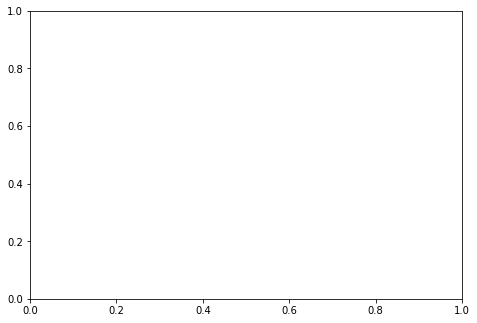

In [9]:
# load params from the json file to create the parameter server object
params = ParameterServer(filename="data/params/gail_params.json")

# customized parameters:
params["ML"]["Settings"]["GPUUse"] = gpu
tf2rl_params = params["ML"]["GAILRunner"]["tf2rl"]
tf2rl_params["max_steps"] = max_steps
tf2rl_params["test_interval"] = test_interval
tf2rl_params["test_episodes"] = test_episodes
params["ML"]["GAILRunner"]["tf2rl"] = tf2rl_params
if params["ML"]["BehaviorGAILAgent"]["WarmUp"] > max_steps / 2:
    params["ML"]["BehaviorGAILAgent"]["WarmUp"] = max_steps / 2

# create environment
bp = ContinuousMergingBlueprint(params,
                                number_of_senarios=500,
                                random_seed=0)
env = SingleAgentRuntime(blueprint=bp,
                         render=False)

# wrapped environment for compatibility with tf2rl
wrapped_env = TF2RLWrapper(env, 
                           normalize_features=params["ML"]["Settings"]["NormalizeFeatures"])

# instantiate the GAIL agent
gail_agent = BehaviorGAILAgent(environment=wrapped_env,
                               params=params)

# load the expert trajectories
expert_trajectories, _, _ = load_expert_trajectories(
    params['ML']['ExpertTrajectories']['expert_path_dir'],
    normalize_features=params["ML"]["Settings"]["NormalizeFeatures"],
    env=env, # the unwrapped env has to be used, since that contains the unnormalized spaces.
    subset_size=params["ML"]["ExpertTrajectories"]["subset_size"]
    ) 

# instantiate a runner that is going to train the agent
runner = GAILRunner(params=params,
                 environment=wrapped_env,
                 agent=gail_agent,
                 expert_trajs=expert_trajectories)

# train the agent
runner.Train()

# Visualization of a trained agent 

Lastly we show you how a trained agent interacts with the environment.
Therefore, please set up the number of scenarios to visualize in the next cell.

In [10]:
# number of scenarios to visualize
num_scenarios_to_visualize = 10

In [11]:
# load params from the json file to create the parameter server object
params = ParameterServer(filename="data/params/gail_params.json")

# setting the path for the pretrained agent.
params["ML"]["GAILRunner"]["tf2rl"]["model_dir"] = "../../../com_github_gail_4_bark_large_data_store/pretrained_agents/gail/merging"

# customized parameters:
params["ML"]["Settings"]["GPUUse"] = gpu
tf2rl_params = params["ML"]["GAILRunner"]["tf2rl"]
tf2rl_params["max_steps"] = max_steps
tf2rl_params["test_interval"] = test_interval
tf2rl_params["test_episodes"] = test_episodes
params["ML"]["GAILRunner"]["tf2rl"] = tf2rl_params
if params["ML"]["BehaviorGAILAgent"]["WarmUp"] > max_steps / 2:
    params["ML"]["BehaviorGAILAgent"]["WarmUp"] = max_steps / 2

# create environment
bp = ContinuousMergingBlueprint(params,
                              number_of_senarios=500,
                              random_seed=0)
env = SingleAgentRuntime(blueprint=bp,
                      render=False)

# wrapped environment for compatibility with tf2rl
wrapped_env = TF2RLWrapper(env, 
normalize_features=params["ML"]["Settings"]["NormalizeFeatures"])

# instantiate the GAIL agent
gail_agent = BehaviorGAILAgent(environment=wrapped_env,
                           params=params)

# instantiate a runner that is going to train the agent.
runner = GAILRunner(params=params,
                 environment=wrapped_env,
                 agent=gail_agent,)

# Visualize the agent
runner.Visualize(num_scenarios_to_visualize, renderer="matplotlib_jupyter")

/home/brucknem/.cache/bazel/_bazel_brucknem/5babddc60bc977a08450e544bfdcfbae/execroot/bark_ml/bazel-out/k8-fastbuild/bin/docs/report/run.runfiles/bark_project/bark/runtime/viewer/matplotlib_viewer.py:49: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  linewidth=linewidth)
/home/brucknem/.cache/bazel/_bazel_brucknem/5babddc60bc977a08450e544bfdcfbae/execroot/bark_ml/bazel-out/k8-fastbuild/bin/docs/report/run.runfiles/bark_project/bark/runtime/viewer/matplotlib_viewer.py:49: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  linewidth=linewidth)
/home/brucknem/.cache/bazel/_bazel_brucknem/5babddc60bc977a08450e544bfdcfbae/execroot/bark_ml/bazel-out/k8-fastbuild/bin/docs/report/run.runfiles/bark_project/bark/runtime/viewer/matplotlib_viewer.py:49: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated 

KeyboardInterrupt: 